In [3]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

In [4]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)


'''
#short-cut to get the result from the first step:

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

'''

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)


"\n#short-cut to get the result from the first step:\n\ncnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}\ny_pred = run_cnn(cnn_data)\ncropped = get_cropped(img_test, y_pred, win_size = 100)\n\nprint(y_pred.shape)\n\n"

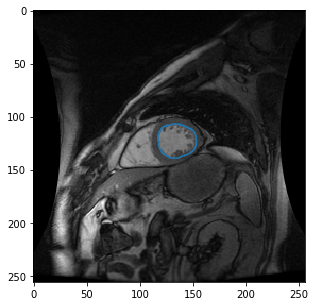

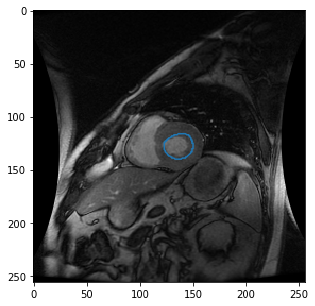

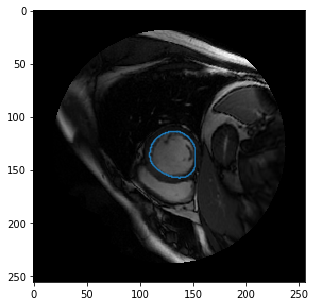

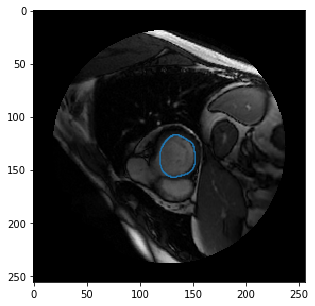

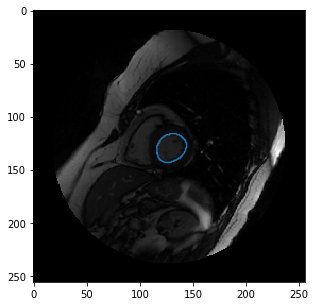

In [5]:
for i in range(5):
    contour = contour_train[i * 10]
    coord = contour.ctr
    img = img_train[i * 10,:,:,0]
    
    plt.figure(figsize=(5,5))
    #plt.imshow(image_part)
    plt.imshow(img, cmap='gray')
    plt.plot(*zip(*coord))
    plt.show()

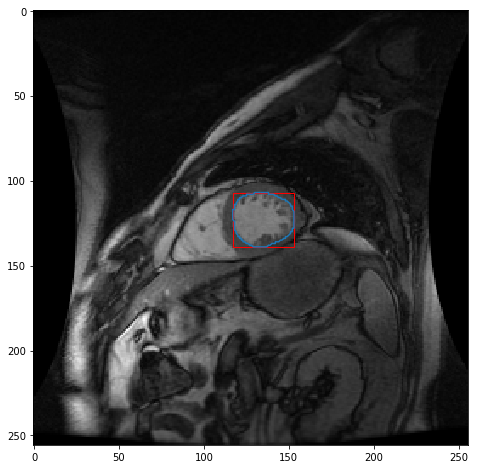

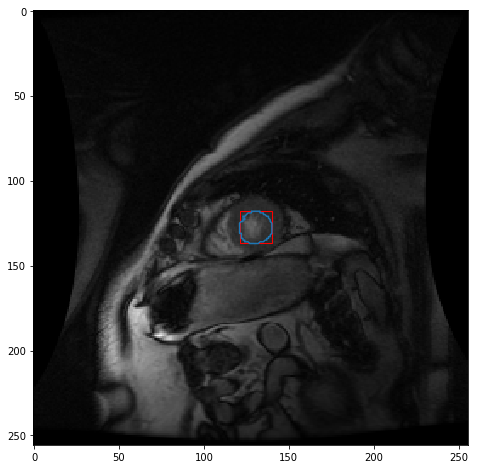

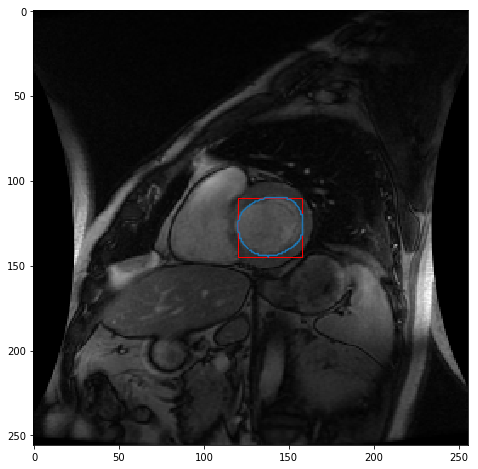

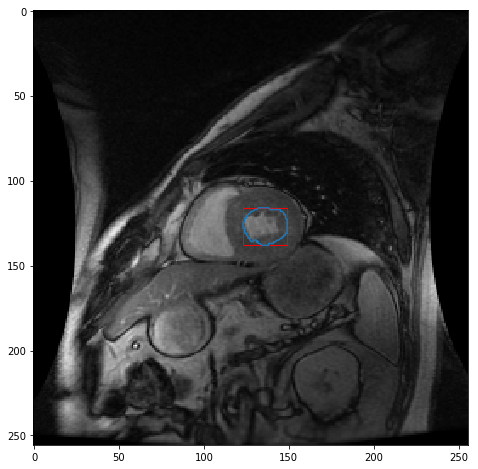

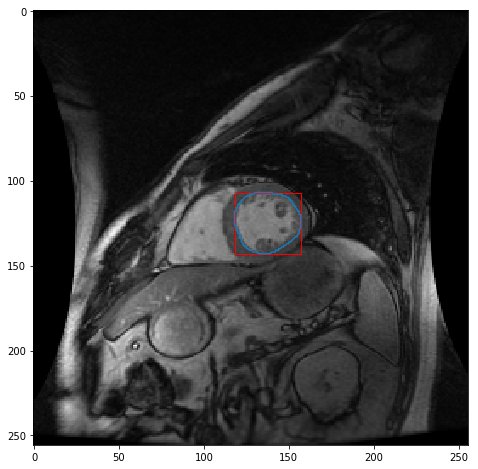

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
for i in range(5):
    contour = contour_train[i]
    coord = contour.ctr
    coord = np.array(coord)
    mask = mask_train[i, :, :, 0]
    img = img_train[i, :, :, 0]
    X_min, Y_min = coord[:,0].min(), coord[:,1].min()
    X_max, Y_max = coord[:, 0].max(), coord[:, 1].max()
    w = coord[:,0].max() - coord[:,0].min() 
    h = coord[:,1].max() - coord[:,1].min()
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(img, cmap = 'gray')
    ax.plot(*zip(*coord))
    bbox = patches.Rectangle(
            (X_min, Y_min),
            w, h,
            linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(bbox)

In [7]:
print(X.shape)
print(Y.shape)

(526, 64, 64, 1)
(526, 1, 32, 32)


In [8]:
def create_model_maxpooling(activation, input_shape=(64, 64)):
    """
    Simple convnet model with max pooling: one convolution, one max pooling and one fully connected layer
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(MaxPooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model
def create_model_deeper(activation, input_shape=(64, 64)):
    """
    Deeper convnet model : two convolutions, two average pooling and one fully connected layer:
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(64, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((2,2)))
    model.add(Conv2D(128, (10, 10), activation=activation, padding='valid', strides=(1, 1)))
    model.add(AveragePooling2D((2,2)))
    model.add(Reshape([-1, 128*9*9]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model


In [9]:
model = create_model_maxpooling('relu')
for p in model.layers:
    print(p.name.title(), p.input_shape, p.output_shape)

('Conv2D_1', (None, 64, 64, 1), (None, 54, 54, 100))
('Max_Pooling2D_1', (None, 54, 54, 100), (None, 9, 9, 100))
('Reshape_1', (None, 9, 9, 100), (None, 1, 8100))
('Dense_1', (None, 1, 8100), (None, 1, 1024))
('Reshape_2', (None, 1, 1024), (None, 1, 32, 32))


In [14]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
def create_baseline_model(activation = 'relu', input_shape=(64, 64)):
    model = Sequential()
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model
plot_model(create_baseline_model(), to_file='baseline.png', show_shapes=True, show_layer_names=True)



In [7]:
m = create_maxpooling_model()
m.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
h = training(m, X, Y, batch_size=16, epochs= 10, data_augm=False)

Epoch 1/10
526/526 [==============================] - 8s 15ms/step - loss: 0.1828 - acc: 0.1814
Epoch 2/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0914 - acc: 0.3135
Epoch 3/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0676 - acc: 0.1300
Epoch 4/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0534 - acc: 0.0356
Epoch 5/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0443 - acc: 0.0321
Epoch 6/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0392 - acc: 0.0332
Epoch 7/10
526/526 [==============================] - 7s 12ms/step - loss: 0.0345 - acc: 0.0421
Epoch 8/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0299 - acc: 0.0523
Epoch 9/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0272 - acc: 0.0640
Epoch 10/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0260 - acc: 0.0768


Epoch 1/10
526/526 [==============================] - 8s 15ms/step - loss: 0.1819 - acc: 0.2814
Epoch 2/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0993 - acc: 0.2407
Epoch 3/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0689 - acc: 0.1292
Epoch 4/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0520 - acc: 0.0992
Epoch 5/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0420 - acc: 0.0754
Epoch 6/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0359 - acc: 0.0658
Epoch 7/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0309 - acc: 0.0602
Epoch 8/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0272 - acc: 0.0596
Epoch 9/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0252 - acc: 0.0759
Epoch 10/10
526/526 [==============================] - 6s 12ms/step - loss: 0.0254 - acc: 0.0715
Epoch 1/10
526/526 [===================

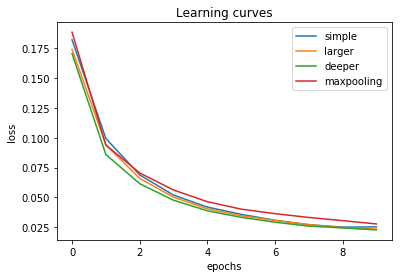

In [8]:
variants = ['simple', 'larger', 'deeper', 'maxpooling']
for k in variants:
    if k == 'simple':
        m = create_baseline_model()
    elif k == 'larger':
        m = create_model_larger()
    elif k == 'deeper':
        m = create_model_deeper()
    elif k == 'maxpooling':
        m = create_maxpooling_model()
    m.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    h = training(m, X, Y, batch_size=16, epochs= 10, data_augm=False)
    plt.plot(range(len(h.history['loss'])), h.history['loss'], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curves")
plt.legend()

In [4]:
from keras.models import load_model
#model = load_model('./bbox_model.h5')

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
h = training(model, X, Y, batch_size=16, epochs= 10, data_augm=False)
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curve")

NameError: name 'model' is not defined

In [ ]:
model.save('./bbox_model.h5')

In [4]:
from keras.models import load_model
model = load_model('./cnn_model_saved.h5')

In [5]:
y_pred = model.predict(X_test, batch_size = 16)

In [18]:
print(y_pred.shape)

(279, 1, 32, 32)


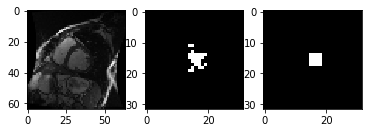

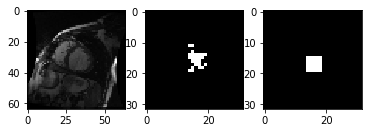

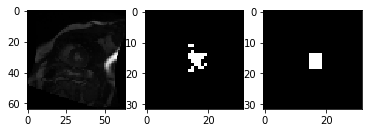

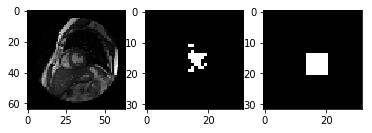

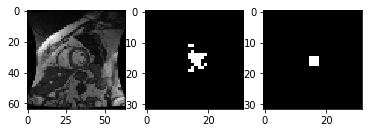

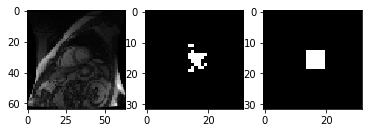

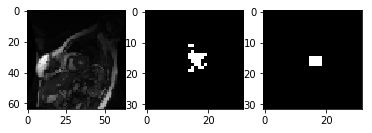

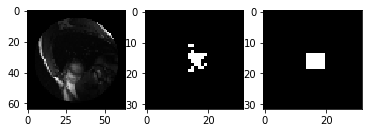

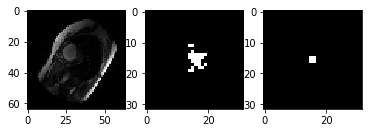

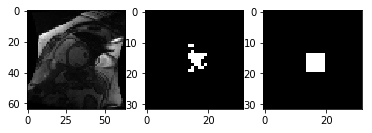

In [19]:
for i in range(10):
    mask = y_pred[i * 20, 0, :, :]
    img = X_test[i * 20, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(ROI_val[i],cmap='gray')

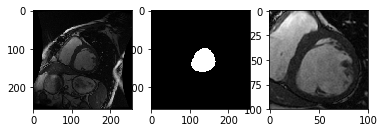

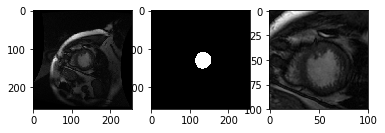

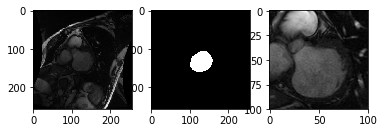

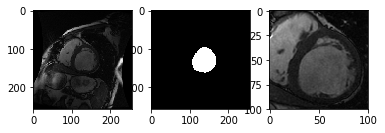

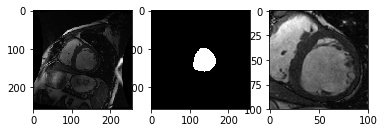

In [20]:
cropped = get_cropped(img_test, y_pred, win_size = 100)
## the size of cropping could be adjusted, should be tuned in terms of a few metrics...

for i in range(5):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_test[i, :, :, 0], cmap = 'gray')
    plt.subplot(132)
    
    plt.imshow(mask_test[i,:,:,0], cmap = 'gray')
    plt.subplot(133)
    plt.imshow(cropped[i, :,:,0], cmap = 'gray')

Normalized confusion matrix
[[0.91978224 0.08021776]
 [0.00233064 0.99766936]]


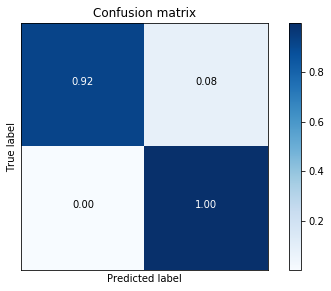

In [6]:
#results on test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y_true = mask_test
y_pred = model.predict(X_test)
cm = get_confusion_matrix_bbox(y_true, y_pred)
plot_confusion_matrix(cm, [], normalize=True)

In [15]:
def get_precision_recall_bbox(mask, y_pred):
    '''
        Using confusion matrix to evaluate the performance of cropping
        For each mask - pred pair, compute the bbox of pred, regard mask as ground truth, bbox as prediction,
        apply confusion matrix metrics. After that, average over all confusion matrix.
    '''
    pred_box = np.zeros((mask.shape))
    n = mask.shape[0]
    for i in range(n):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        pred_box[i,  x_min:x_max, y_min:y_max, 0] = 1
    pred_box = np.reshape(pred_box, [n, pred_box.shape[1]*pred_box.shape[1]])
    mask = np.reshape(mask, [n, mask.shape[1] * mask.shape[1]])
    #cm = confusion_matrix(mask, pred_box)
    prec = []
    recall = []
    for i in range(n):
        prec = np.append(prec, precision_score(mask[i,:], pred_box[i,:], average='macro'))
        recall = np.append(recall, recall_score(mask[i,:], pred_box[i,:], average='macro'))
    return prec, recall

In [10]:
prec, recall = get_precision_recall_bbox(y_true, y_pred)

In [14]:
print(np.mean(prec))
print(np.mean(recall))

0.5970671868454126
0.9590463613185569


In [7]:
print(y_true.shape)

(279, 256, 256, 1)
